All libraries imported successfully!

Data loaded successfully!
Train data shape: (18524, 9)
Test data shape: (6175, 8)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


Calculated scale_pos_weight for XGBoost (class 1): 2.84

--- Starting Hyperparameter Tuning for XGBoost Pipeline ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/khaijones/.conda/envs/kaggle_introvert_extrovert_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:57:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaijones/.conda/envs/kaggle_introvert_extrovert_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:57:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaijones/.conda/envs/kaggle_introvert_extrovert_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:57:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration


XGBoost Pipeline Hyperparameter tuning complete.
Best parameters found (XGBoost): {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best cross-validation score (XGBoost - Accuracy): 0.9675

--- Evaluation with Best XGBoost Pipeline on Validation Set ---
Classification Report (Best XGBoost Pipeline):
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705

Accuracy (Best XGBoost Pipeline): 0.9709
ROC AUC Score (Best XGBoost Pipeline): 0.9711

--- Generating Confusion Matrix ---


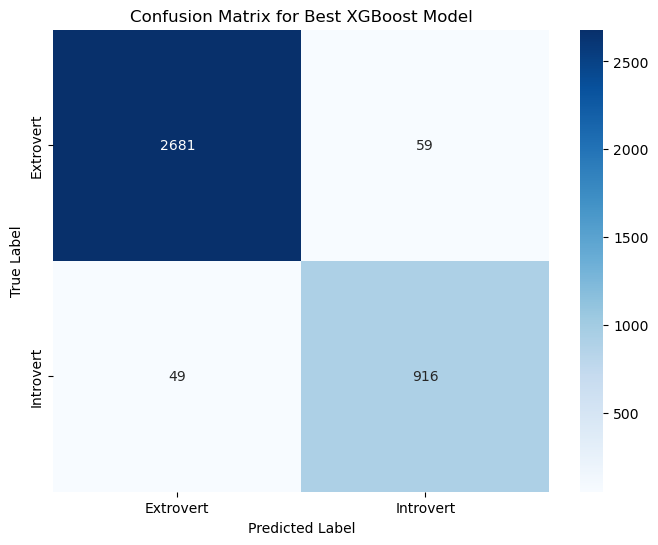


--- Generating Feature Importance Plot ---
Could not plot feature importances. This can be complex with pipelines. Error: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

--- Saving Best Overall Model (Full Pipeline) ---
Best model pipeline saved to: best_personality_pipeline.joblib

Done with model creation, tuning, evaluation, and saving.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from IPython.display import display
import joblib
import xgboost as xgb
import optuna # NEW IMPORT for advanced tuning

print("All libraries imported successfully!")

# --- Data Loading (No Changes) ---
try:
    train_df = pd.read_csv('../data/raw/train.csv')
    test_df = pd.read_csv('../data/raw/test.csv')
    sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
    print("\nData loaded successfully!")
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError:
    print("Error: Make sure 'train.csv', 'test.csv', and 'sample_submission.csv' are in the 'data/raw/' directory.")
    train_df = pd.DataFrame() # Avoid crashing script

if not train_df.empty:
    display(train_df.head())

# --- IMPROVEMENT 1: Custom Transformer for Feature Engineering ---
# This class wraps your feature engineering logic to be used within a scikit-learn Pipeline.
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self # Nothing to learn during fitting, so we just return self

    def transform(self, X, y=None):
        df = X.copy()
        epsilon = 1e-6

        # --- All feature engineering logic is now inside this class ---
        df['alone_to_social_ratio'] = df['Time_spent_Alone'] / (df['Social_event_attendance'] + epsilon)
        df['social_anxiety_score'] = df['Drained_after_socializing'] + df['Stage_fear']
        df['outside_per_post'] = df['Going_outside'] / (df['Post_frequency'] + epsilon)
        df['friends_to_social_events'] = df['Friends_circle_size'] / (df['Social_event_attendance'] + epsilon)
        df['alone_x_drained'] = df['Time_spent_Alone'] * df['Drained_after_socializing']
        df['stage_fear_x_outside'] = df['Stage_fear'] * df['Going_outside']
        df['social_events_x_friends'] = df['Social_event_attendance'] * df['Friends_circle_size']
        df['posts_x_friends'] = df['Post_frequency'] * df['Friends_circle_size']
        df['alone_x_social_anxiety'] = df['Time_spent_Alone'] * df['social_anxiety_score']
        df['outside_x_drained'] = df['Going_outside'] * df['Drained_after_socializing']
        df['Time_spent_Alone_sq'] = df['Time_spent_Alone']**2
        df['Going_outside_sq'] = df['Going_outside']**2
        df['Friends_circle_size_sq'] = df['Friends_circle_size']**2
        df['Post_frequency_sq'] = df['Post_frequency']**2

        for col in ['Time_spent_Alone', 'Going_outside', 'Friends_circle_size', 'Post_frequency', 'Social_event_attendance']:
            if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
                 # The log transformation is applied within the pipeline
                 df[f'{col}_log'] = np.log1p(df[col])

        df['total_social_engagement'] = df['Social_event_attendance'] + df['Friends_circle_size'] + df['Post_frequency']
        df['posts_per_event'] = df['Post_frequency'] / (df['Social_event_attendance'] + epsilon)
        df['alone_vs_outside'] = df['Time_spent_Alone'] / (df['Going_outside'] + epsilon)
        df['net_social_battery'] = df['Social_event_attendance'] - df['Drained_after_socializing']

        return df

# --- Data Preparation Workflow ---
if 'id' in train_df.columns:
    X_raw = train_df.drop(columns=['id', 'Personality']).copy()
else:
    X_raw = train_df.drop(columns=['Personality']).copy()

y_raw = train_df['Personality']

# --- Encode specific binary categorical features ('Yes'/'No') to numerical (0/1) ---
# This is a prerequisite step before the pipeline
binary_map = {'No': 0, 'Yes': 1}
for col in ['Drained_after_socializing', 'Stage_fear']:
    if col in X_raw.columns:
        X_raw[col] = X_raw[col].map(binary_map).fillna(0) # Fill NaNs with 0 ('No')
        X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

# Encode the target variable (y)
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
joblib.dump(le, 'label_encoder.joblib') # Save the label encoder

# Split the RAW data. The pipeline will handle engineering and preprocessing.
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Define the Preprocessor using column names from the *engineered* data ---
# We do a one-time transform on the training data just to get the final column names for the preprocessor
temp_feature_engineer = FeatureEngineer()
X_train_engineered_temp = temp_feature_engineer.fit_transform(X_train)

numerical_cols = X_train_engineered_temp.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_engineered_temp.select_dtypes(include=['object', 'category']).columns.tolist()

# Define the preprocessor that will be part of the main pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)


# --- IMPROVEMENT 2: Create a Full Pipeline for XGBoost ---
# This combines feature engineering, preprocessing, and the model into one object.

# Calculate scale_pos_weight for XGBoost
neg_count = pd.Series(y_train).value_counts()[0]
pos_count = pd.Series(y_train).value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight for XGBoost (class 1): {scale_pos_weight_value:.2f}\n")


# The master pipeline
xgb_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value
    ))
])

# --- Hyperparameter Tuning for the Full XGBoost Pipeline ---
print("--- Starting Hyperparameter Tuning for XGBoost Pipeline ---")

# Parameters must now reference the step name in the pipeline (e.g., 'classifier__n_estimators')
param_grid_xgb_pipeline = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline, # Use the full pipeline here
    param_grid=param_grid_xgb_pipeline,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the entire pipeline on the RAW training data
grid_search_xgb.fit(X_train, y_train)

print("\nXGBoost Pipeline Hyperparameter tuning complete.")
print(f"Best parameters found (XGBoost): {grid_search_xgb.best_params_}")
print(f"Best cross-validation score (XGBoost - Accuracy): {grid_search_xgb.best_score_:.4f}")

# The best estimator is the entire fitted pipeline
best_pipeline = grid_search_xgb.best_estimator_

# --- IMPROVEMENT 3: Deeper Evaluation of the Best Model ---
print("\n--- Evaluation with Best XGBoost Pipeline on Validation Set ---")
y_val_pred_best_xgb = best_pipeline.predict(X_val)
y_val_prob_best_xgb = best_pipeline.predict_proba(X_val)[:, 1]

print("Classification Report (Best XGBoost Pipeline):")
print(classification_report(y_val, y_val_pred_best_xgb, target_names=le.classes_))
print(f"Accuracy (Best XGBoost Pipeline): {accuracy_score(y_val, y_val_pred_best_xgb):.4f}")
print(f"ROC AUC Score (Best XGBoost Pipeline): {roc_auc_score(y_val, y_val_prob_best_xgb):.4f}")

# --- NEW: Confusion Matrix Visualization ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_val, y_val_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best XGBoost Model')
plt.show()

# --- NEW: Feature Importance Plot ---
print("\n--- Generating Feature Importance Plot ---")
try:
    # Get components from the best pipeline
    feature_engineer = best_pipeline.named_steps['feature_engineering']
    preprocessor = best_pipeline.named_steps['preprocessing']
    classifier = best_pipeline.named_steps['classifier']

    # Get feature names after all transformations
    ohe_cols = preprocessor.named_transformers_['cat_pipeline']['onehot'].get_feature_names_out(categorical_cols)
    all_final_features = numerical_cols + list(ohe_cols)

    # Create and display the plot
    importance_df = pd.DataFrame({
        'feature': all_final_features,
        'importance': classifier.feature_importances_
    }).sort_values('importance', ascending=False).head(20) # Top 20

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Top 20 Feature Importances from XGBoost Model')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot feature importances. This can be complex with pipelines. Error: {e}")

# --- Model Persistence ---
print("\n--- Saving Best Overall Model (Full Pipeline) ---")
# The object to save is the entire 'best_pipeline'
model_filename = 'best_personality_pipeline.joblib'
joblib.dump(best_pipeline, model_filename)
print(f"Best model pipeline saved to: {model_filename}")

print("\nDone with model creation, tuning, evaluation, and saving.")

# --- IMPROVEMENT 4 (Optional): Advanced Tuning with Optuna ---
# This section is for reference and can be run instead of GridSearchCV for more efficient tuning.
#
# def objective(trial):
#     params = {
#         'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 1000, step=50),
#         'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.3, log=True),
#         'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 10),
#         'classifier__subsample': trial.suggest_float('classifier__subsample', 0.6, 1.0),
#         'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.6, 1.0),
#     }
#     pipeline = xgb_pipeline.set_params(**params)
#     pipeline.fit(X_train, y_train)
#     preds = pipeline.predict(X_val)
#     accuracy = accuracy_score(y_val, preds)
#     return accuracy
#
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50) # Run 50 trials
#
# print("\nOptuna study complete.")
# print(f"Best validation accuracy: {study.best_value}")
# print(f"Best params: {study.best_params}")
#